# Learning Stock Market Word Embeddings from StockTwits Messages

In this tutorial, we will learn word embeddings related to the stock market using the Word2Vec Skipgram model and StockTwits messages about the Market

We will use the following libraries for our analysis:

* time - time the length of our training iterations
* numpy - numerical computing library used to work with our data
* pandas - data analysis library used to read in our data from csv
* tensorflow - deep learning framework used for modeling
* sklearn - machine learning library we will use this to visualize our embeddings
* matplotlib - visualize embeddings

We will also be using the python Counter object for counting our vocabulary items, the random library from generating random numbers for subsampling and we have a util module that extracts away a lot of the details of our data processing. Please read through the util.py to get a better understanding of how to preprocess the data for analysis.

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import utils as utl

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from collections import Counter
import random

2023-12-05 22:24:46.305112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 22:24:46.388279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 22:24:46.390183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 22:24:47.443846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Processing Data

We will train the model using messages tagged with SPY, the S&P 500 index fund, from [StockTwits.com](https://www.stocktwits.com). StockTwits is a social media network for traders and investors to share their views about the stock market. When a user posts a message, they tag the relevant stock ticker ($SPY in our case) and have the option to tag the messages with their sentiment – “bullish” if they believe the stock will go up and “bearish” if they believe the stock will go down. Here we don't care about the sentiment labels, we will just be using the messages

Our dataset consists of approximately 100,000 messages posted in 2017 that are tagged with $SPY where the user indicated their sentiment. Before we get to our Word2Vec mdeol we have to perform some processing on our data to get it ready for modeling.

#### Read and View Data

First we simply read in our data using pandas, pull out our message and sentiment data into numpy arrays. Let's also take a look at a few samples to get familiar with the data set.

In [2]:
# read data from csv file
data = pd.read_csv("data/StockTwits_SPY_Sentiment_2017.gz",
                   encoding="utf-8",
                   compression="gzip",
                   index_col=0)

# get messages 
messages = data.message.values

# View sample of messages with sentiment
for i in range(10):
    print(messages[i])

$SPY crazy day so far!
$SPY Will make a new ATH this week. Watch it!
$SPY $DJIA white elephant in room is $AAPL. Up 14% since election. Strong headwinds w/Trump trade & Strong dollar. How many 7's do you see?
$SPY blocks above. We break above them We should push to double top
$SPY Nothing happening in the market today, guess I'll go to the store and spend some $.
$SPY What an easy call. Good jobs report: good economy, markets go up.  Bad jobs report: no more rate hikes, markets go up.  Win-win.
$SPY BS market.
$SPY this rally all the cheerleaders were screaming about this morning is pretty weak. I keep adding 2 my short at all spikes
$SPY Dollar ripping higher!
$SPY no reason to go down !


#### Preprocess Messages

Working with raw text data often requires preprocessing the text in some fashion to normalize for context. In our case we want to normalize for known unique "entities" that appear within messages that carry a similar contextual meaning when analyzing sentiment. This means we want to replace references to specific stock tickers, user names, url links or numbers with a special token identifying the "entity". Here we will also make everything lower case and remove punctuation.

In [3]:
messages = np.array([utl.preprocess_ST_message(message) for message in messages])

#### Generate Vocab to Index Mapping

To work with raw text we need some encoding from words to numbers for our algorithm to work with the inputs. The first step of doing this is keeping a collection of our full vocabularly and creating a mapping of each word to a unique index. We will use this word to index mapping in a little bit to prep out messages for analysis.

In [4]:
full_lexicon = " ".join(messages).split()
vocab_to_int, int_to_vocab = utl.create_lookup_tables(full_lexicon)

#### Encode Messages

Earlier we mentioned that we need to "translate" our text to number for our algorithm to take in as inputs. We call this translation an encoding. We encode our messages to sequences of numbers where each nummber is the word index from the mapping we made earlier. The phrase "I am bullish" would now look something like [1, 234, 5345] where each number is the index for the respective word in the message.

In [5]:
encoded_messages = utl.encode_ST_messages(messages, vocab_to_int)

/home/jupyter-xiagh/DSJungle/utils.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(messages_encoded)


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

In [6]:
threshold = 1e-5
word_counts = Counter([word for message in encoded_messages for word in message])
total_count = len([word for message in encoded_messages for word in message])
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_messages = [[word for word in message if random.random() < (1 - p_drop[word])] for message in encoded_messages]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

In [7]:
def get_target(message, window_size=5):
    ''' Get a list of words in a window around an index. '''
    X = []
    Y = []
    for ii in range(len(message)):
        x = message[ii]
        R = np.random.randint(1, window_size+1)
        start = ii - R if (ii - R) > 0 else 0
        stop = ii + R
        target_words = set(message[start:ii] + message[ii+1:stop+1])
        X.extend([x] * len(target_words))
        Y.extend(list(target_words))
    
    return X, Y

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(messages, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(messages)//batch_size
    
    # only full batches
    messages = messages[:n_batches*batch_size]
    
    for idx in range(0, len(messages), batch_size):
        x, y = [], []
        batch = messages[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x, batch_y = get_target(batch[ii], window_size)
            x.extend(batch_x)
            y.extend(batch_y)
        yield x, y

## Building the graph


The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

First off, creating the `inputs` and `labels` placeholders like normal.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.compat.v1.placeholder(tf.int32, [None], name='inputs')
    labels = tf.compat.v1.placeholder(tf.int32, [None, None], name='labels')

## Embedding


The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.compat.v1.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling


For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.compat.v1.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.compat.v1.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.compat.v1.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
# If the checkpoints directory doesn't exist:
# !mkdir checkpoints

In [14]:
epochs = 10
batch_size = 100
window_size = 3

with train_graph.as_default():
    saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.compat.v1.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_messages, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 500 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/sentiment.ckpt")
    embed_mat = sess.run(normalized_embedding)

2023-12-05 22:26:01.576917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Epoch 1/10 Iteration: 100 Avg. Training loss: 5.9273 0.1306 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.8930 0.1212 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.8570 0.1230 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.8300 0.1171 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.7726 0.1370 sec/batch
Nearest to day: amtrak, antitrumpsterskeep, sox, bolli, flashcrash, fridaytodays, tomarrow, horde,
Nearest to for: instructors, lumps, kicked, ramble, taper, onness, optimism, dumpeds,
Nearest to by: g, cashout, forseeable, inverse, ahers, rallywe, dddddddddddoooooooooooowwwwwwwwwwwwnnnnnnnnnnnnnn, evernational,
Nearest to the: caruso, hairman, yearreply, doover, shorttttt, aide, cores, lawdy,
Nearest to what: pinball, canz, superdeflection, rollback, feelingill, winnings, tomorrowfutures, conclude,
Nearest to tomorrow: cruising, startgoing, unbound, spewed, orions, burger, sledding, stupids,
Nearest to i: stoppedusa, growtheasy, optionsx, ta

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

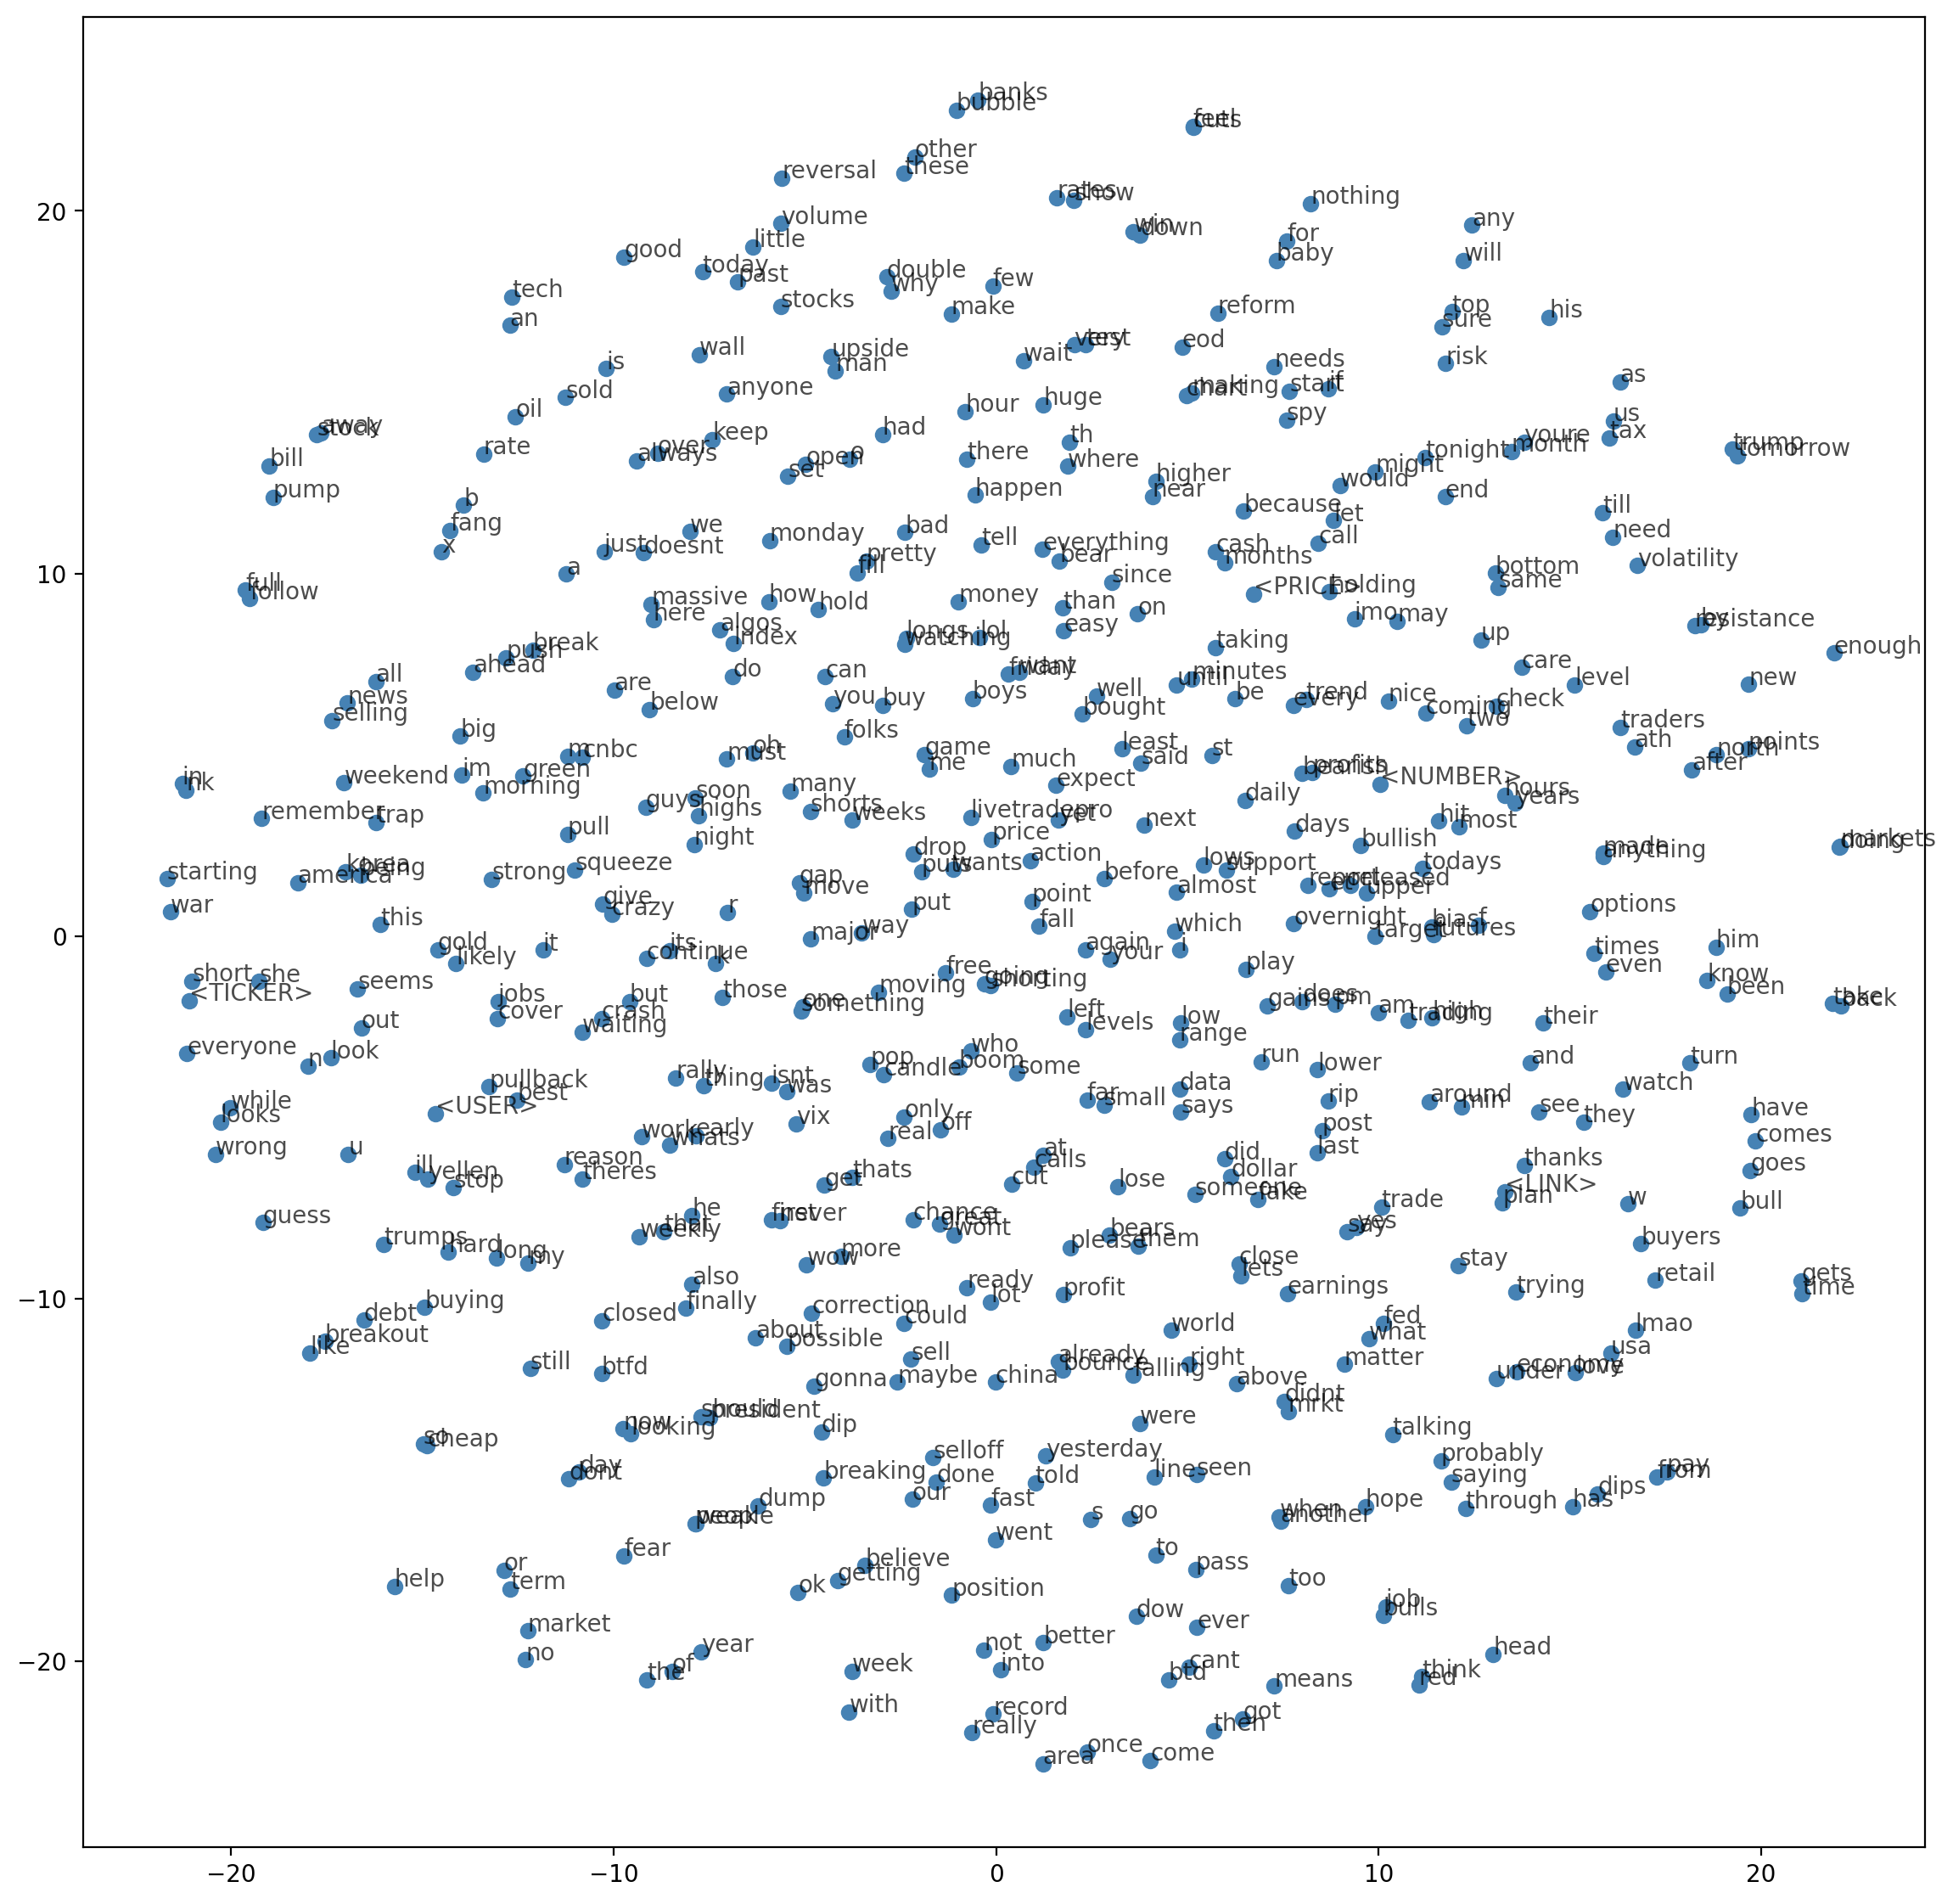

In [17]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(1,viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)